---
title: Results (Julia)
---

In [52]:
using AlgebraOfGraphics
using AlgebraOfGraphics: density
using CairoMakie
using DataFrames
using DataFramesMeta
using Arrow
using PartialFunctions
using LaTeXStrings
using RCall
using Statistics
using beforerr


set_aog_theme!()

include("utils.jl")

:j0_k_norm => (log10 => L"Log Normalized Current Density ($J_A$)")

In [5]:
begin
    dir = "../data/05_reporting"

    j_events_low_fit = load()
    j_events_tau_20_fit = load(tau = 20)
    j_events_high_fit = load(ts = 0.12)

    j_events_low_der = load(method="derivative")
    j_events_high_der = load(ts = 0.12, method="derivative")

    w_events = load("$dir/events.Wind.fit.ts_0.09s_tau_60s.arrow")

    # add a label column to the dataframes
    j_events_low_fit[!, :label] .= "1 Hz (fit)"
    j_events_high_fit[!, :label] .= "8 Hz (fit)"
    j_events_tau_20_fit[!, :label] .= "1 Hz, 20s (fit)"
    j_events_low_der[!, :label] .= "1 Hz (derivative)"
    j_events_high_der[!, :label] .= "8 Hz (derivative)"

    # filter high time resolution events
    j_events_high_fit = @chain j_events_high_fit begin
        filter(:len => >(240), _)
    end

    j_events_der = vcat(j_events_low_der, j_events_high_der, cols=:intersect)

    # combine the dataframes
    j_events = reduce(vcat, [j_events_low_fit, j_events_high_fit, j_events_tau_20_fit])

    j_events = @chain j_events begin
        filter(:"fit.stat.rsquared" => >(0.95), _)
    end

    println("Number of events: ", size(j_events, 1))
end

Number of events: 61879


In [38]:
begin
    log_axis = (yscale=log10, xscale=log10)

    j_limit = (10^-1, 10^1)
    j_norm_limit = (10^-2, 2)
end

(0.010000000000000002, 2)

## Check the discontinuities properties with radial distance

In [13]:
datalimits_f = x -> quantile(x, [0.05, 0.97])

#18 (generic function with 1 method)

In [16]:
# NOTE: log axis for density is not working now
function plot_l_j_r(df)
    fig = Figure(size=(1000, 1000))

    plt = data(df) * mapping(row=:r, color=:label)
    plt = plt * density(datalimits=datalimits_f)

    plt1 = plt * mapping(l_map)
    plt2 = plt * mapping(l_norm_map)
    plt3 = plt * mapping(j_map)
    plt4 = plt * mapping(j_norm_map)

    axis = (; yscale = identity)
    
    # axis = (; yscale=log10, limits=(nothing, nothing, 10^-3, 1))
    # l_axis = (; yscale = log10, limits=(nothing, (10^-5, 10^-3)))
    # l_norm_axis = (; yscale = log10, limits=(nothing, (10^-3, 1)))

    grid1 = draw!(fig[1:5, 1], plt1, axis=axis)
    grid2 = draw!(fig[1:5, 2], plt2, axis=axis)
    grid3 = draw!(fig[1:5, 3], plt3, axis=axis)
    grid4 = draw!(fig[1:5, 4], plt4, axis=axis)
    legend!(fig[0, 1:end], grid1, titleposition=:left, orientation=:horizontal)

    fig
end

plot_l_j_r (generic function with 1 method)

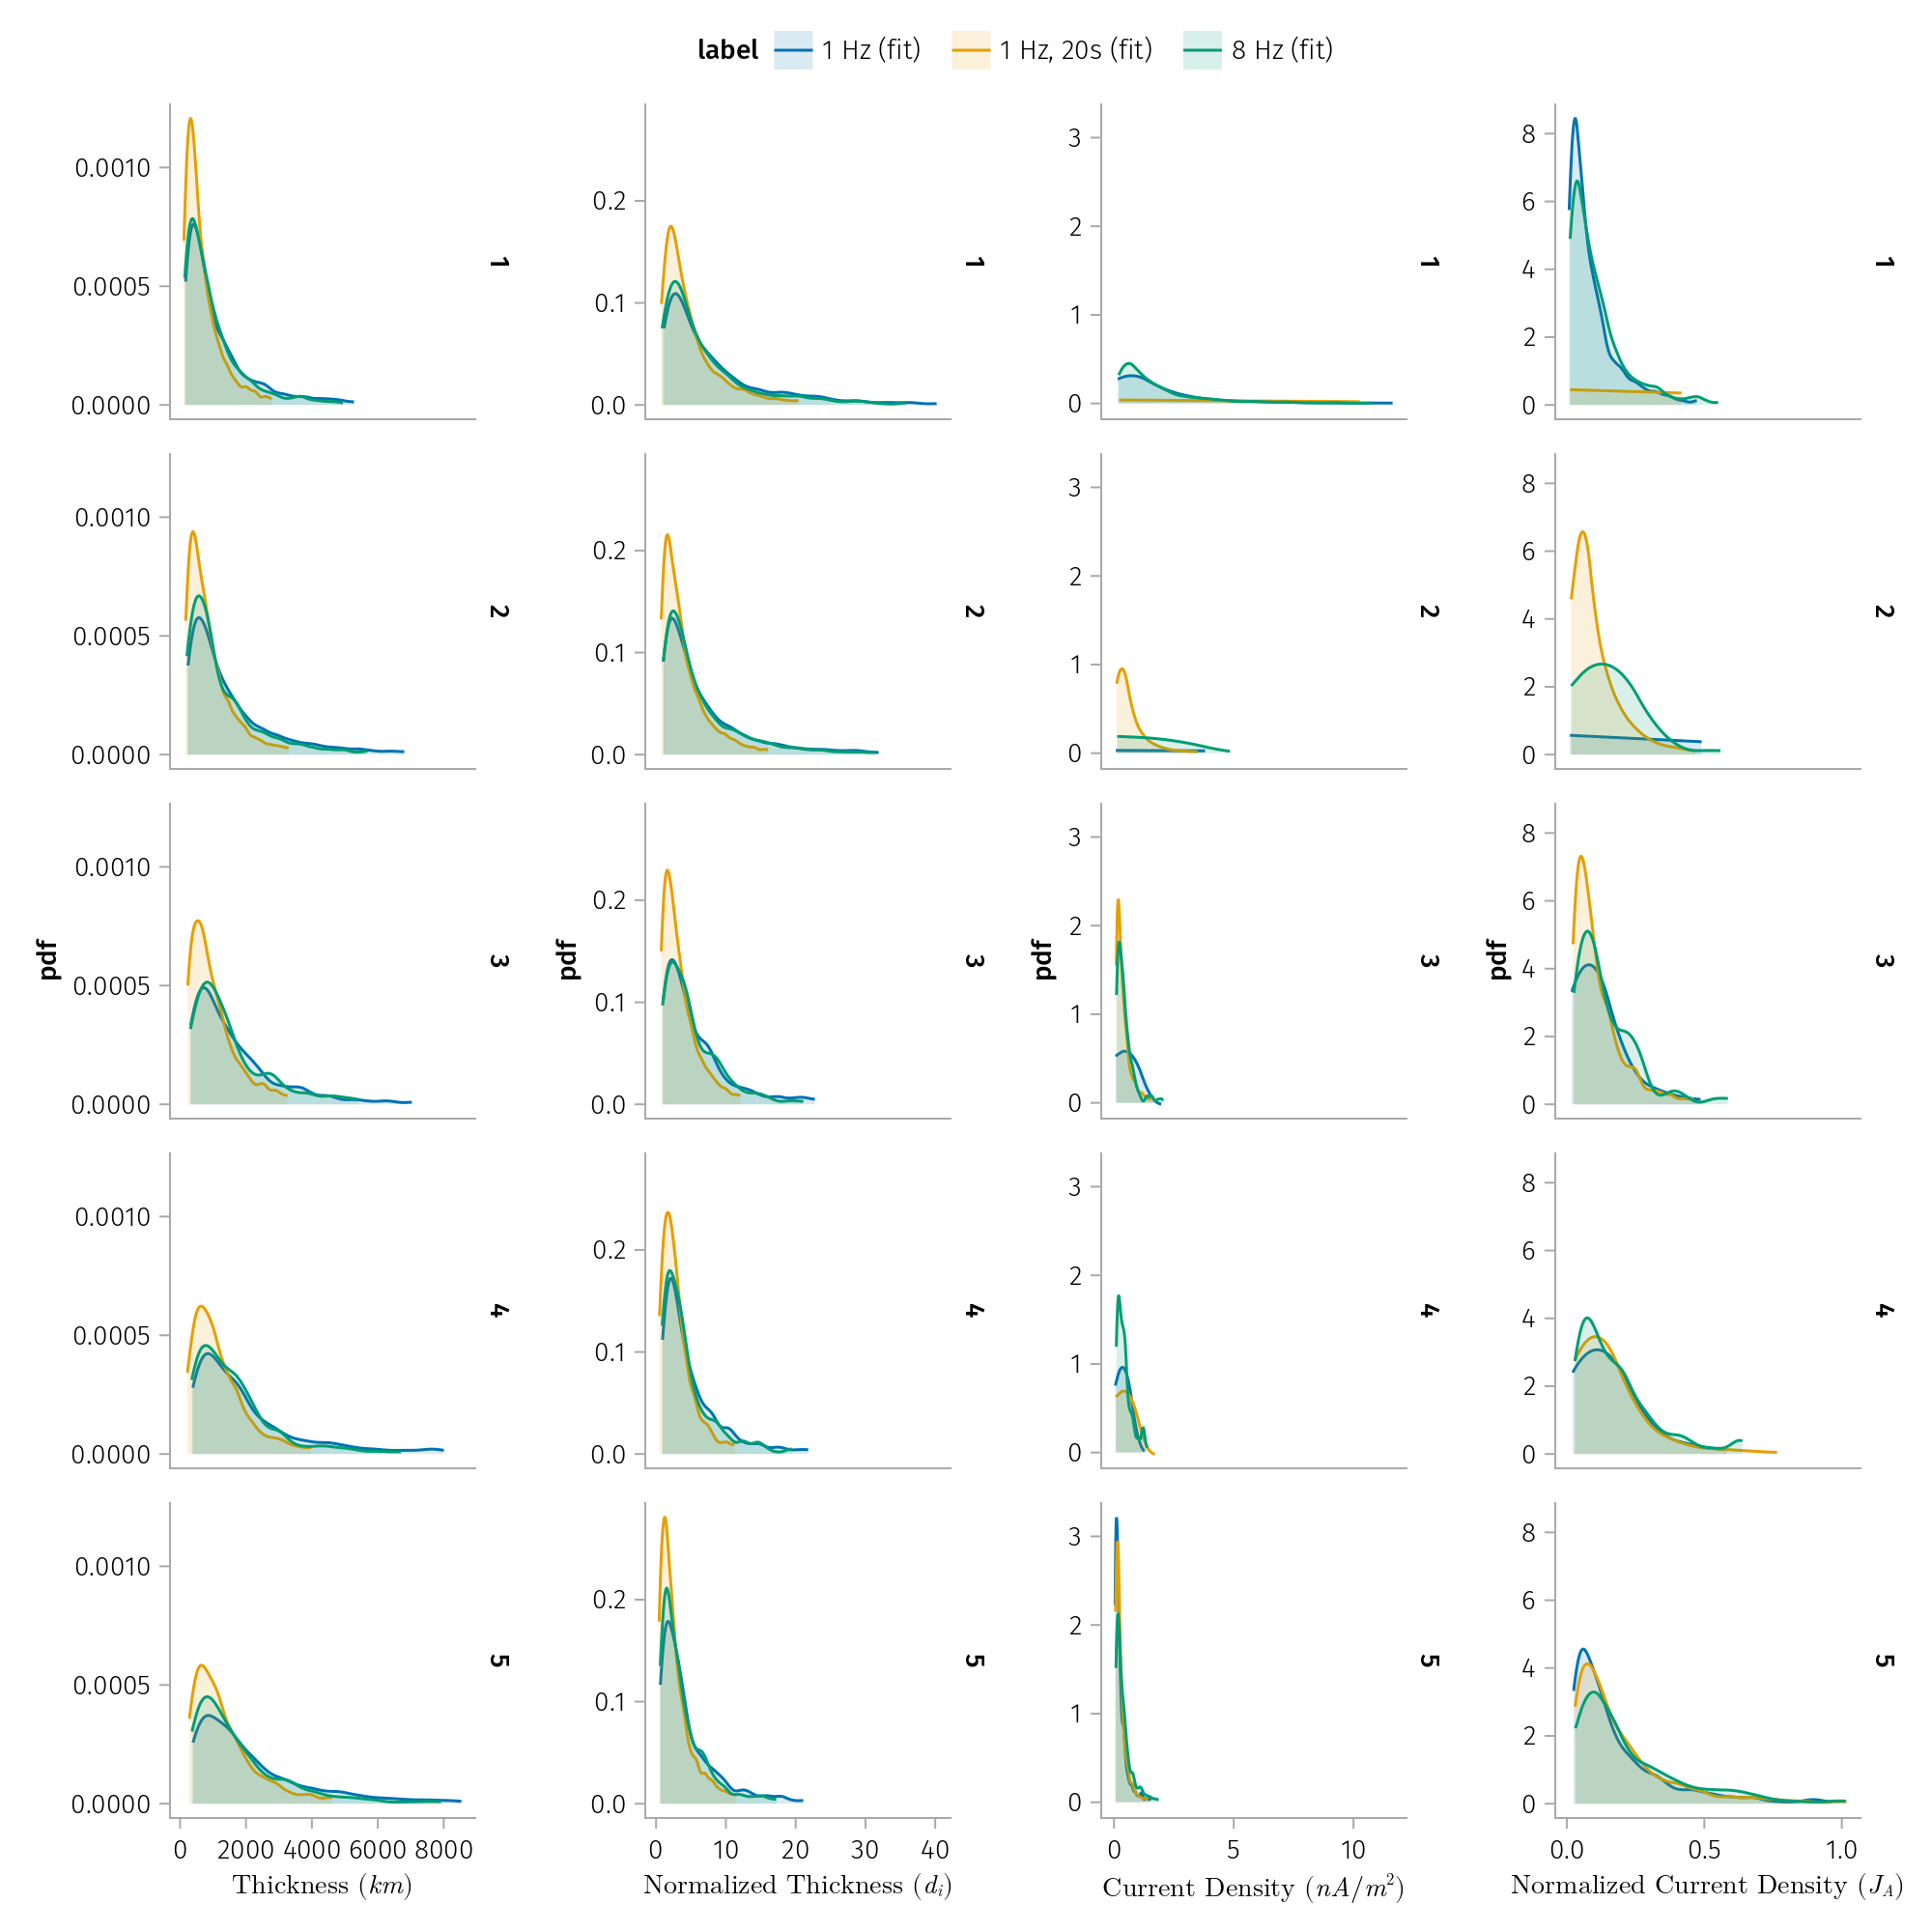

In [17]:
plot_l_j_r(j_events)

In [18]:
function plot_l_j_r_hist(df)
    fig = Figure(size=(1200, 1000))

    plt = data(df) * mapping(row=:r, color=:label) * (visual(Lines) + visual(Scatter))
    plt *= histogram(datalimits=datalimits_f, normalization=:pdf)

    plt1 = plt * mapping(l_map) 
    plt2 = plt * mapping(l_norm_map)
    plt3 = plt * mapping(j_map)
    plt4 = plt * mapping(j_norm_map)

    axis = (; yscale = log10)

    grid1 = draw!(fig[1:5, 1], plt1, axis=axis)
    grid2 = draw!(fig[1:5, 2], plt2, axis=axis)
    grid3 = draw!(fig[1:5, 3], plt3, axis=axis)
    grid4 = draw!(fig[1:5, 4], plt4, axis=axis)
    legend!(fig[0, 1:end], grid1, titleposition=:left, orientation=:horizontal)

    fig
end

plot_l_j_r_hist (generic function with 1 method)

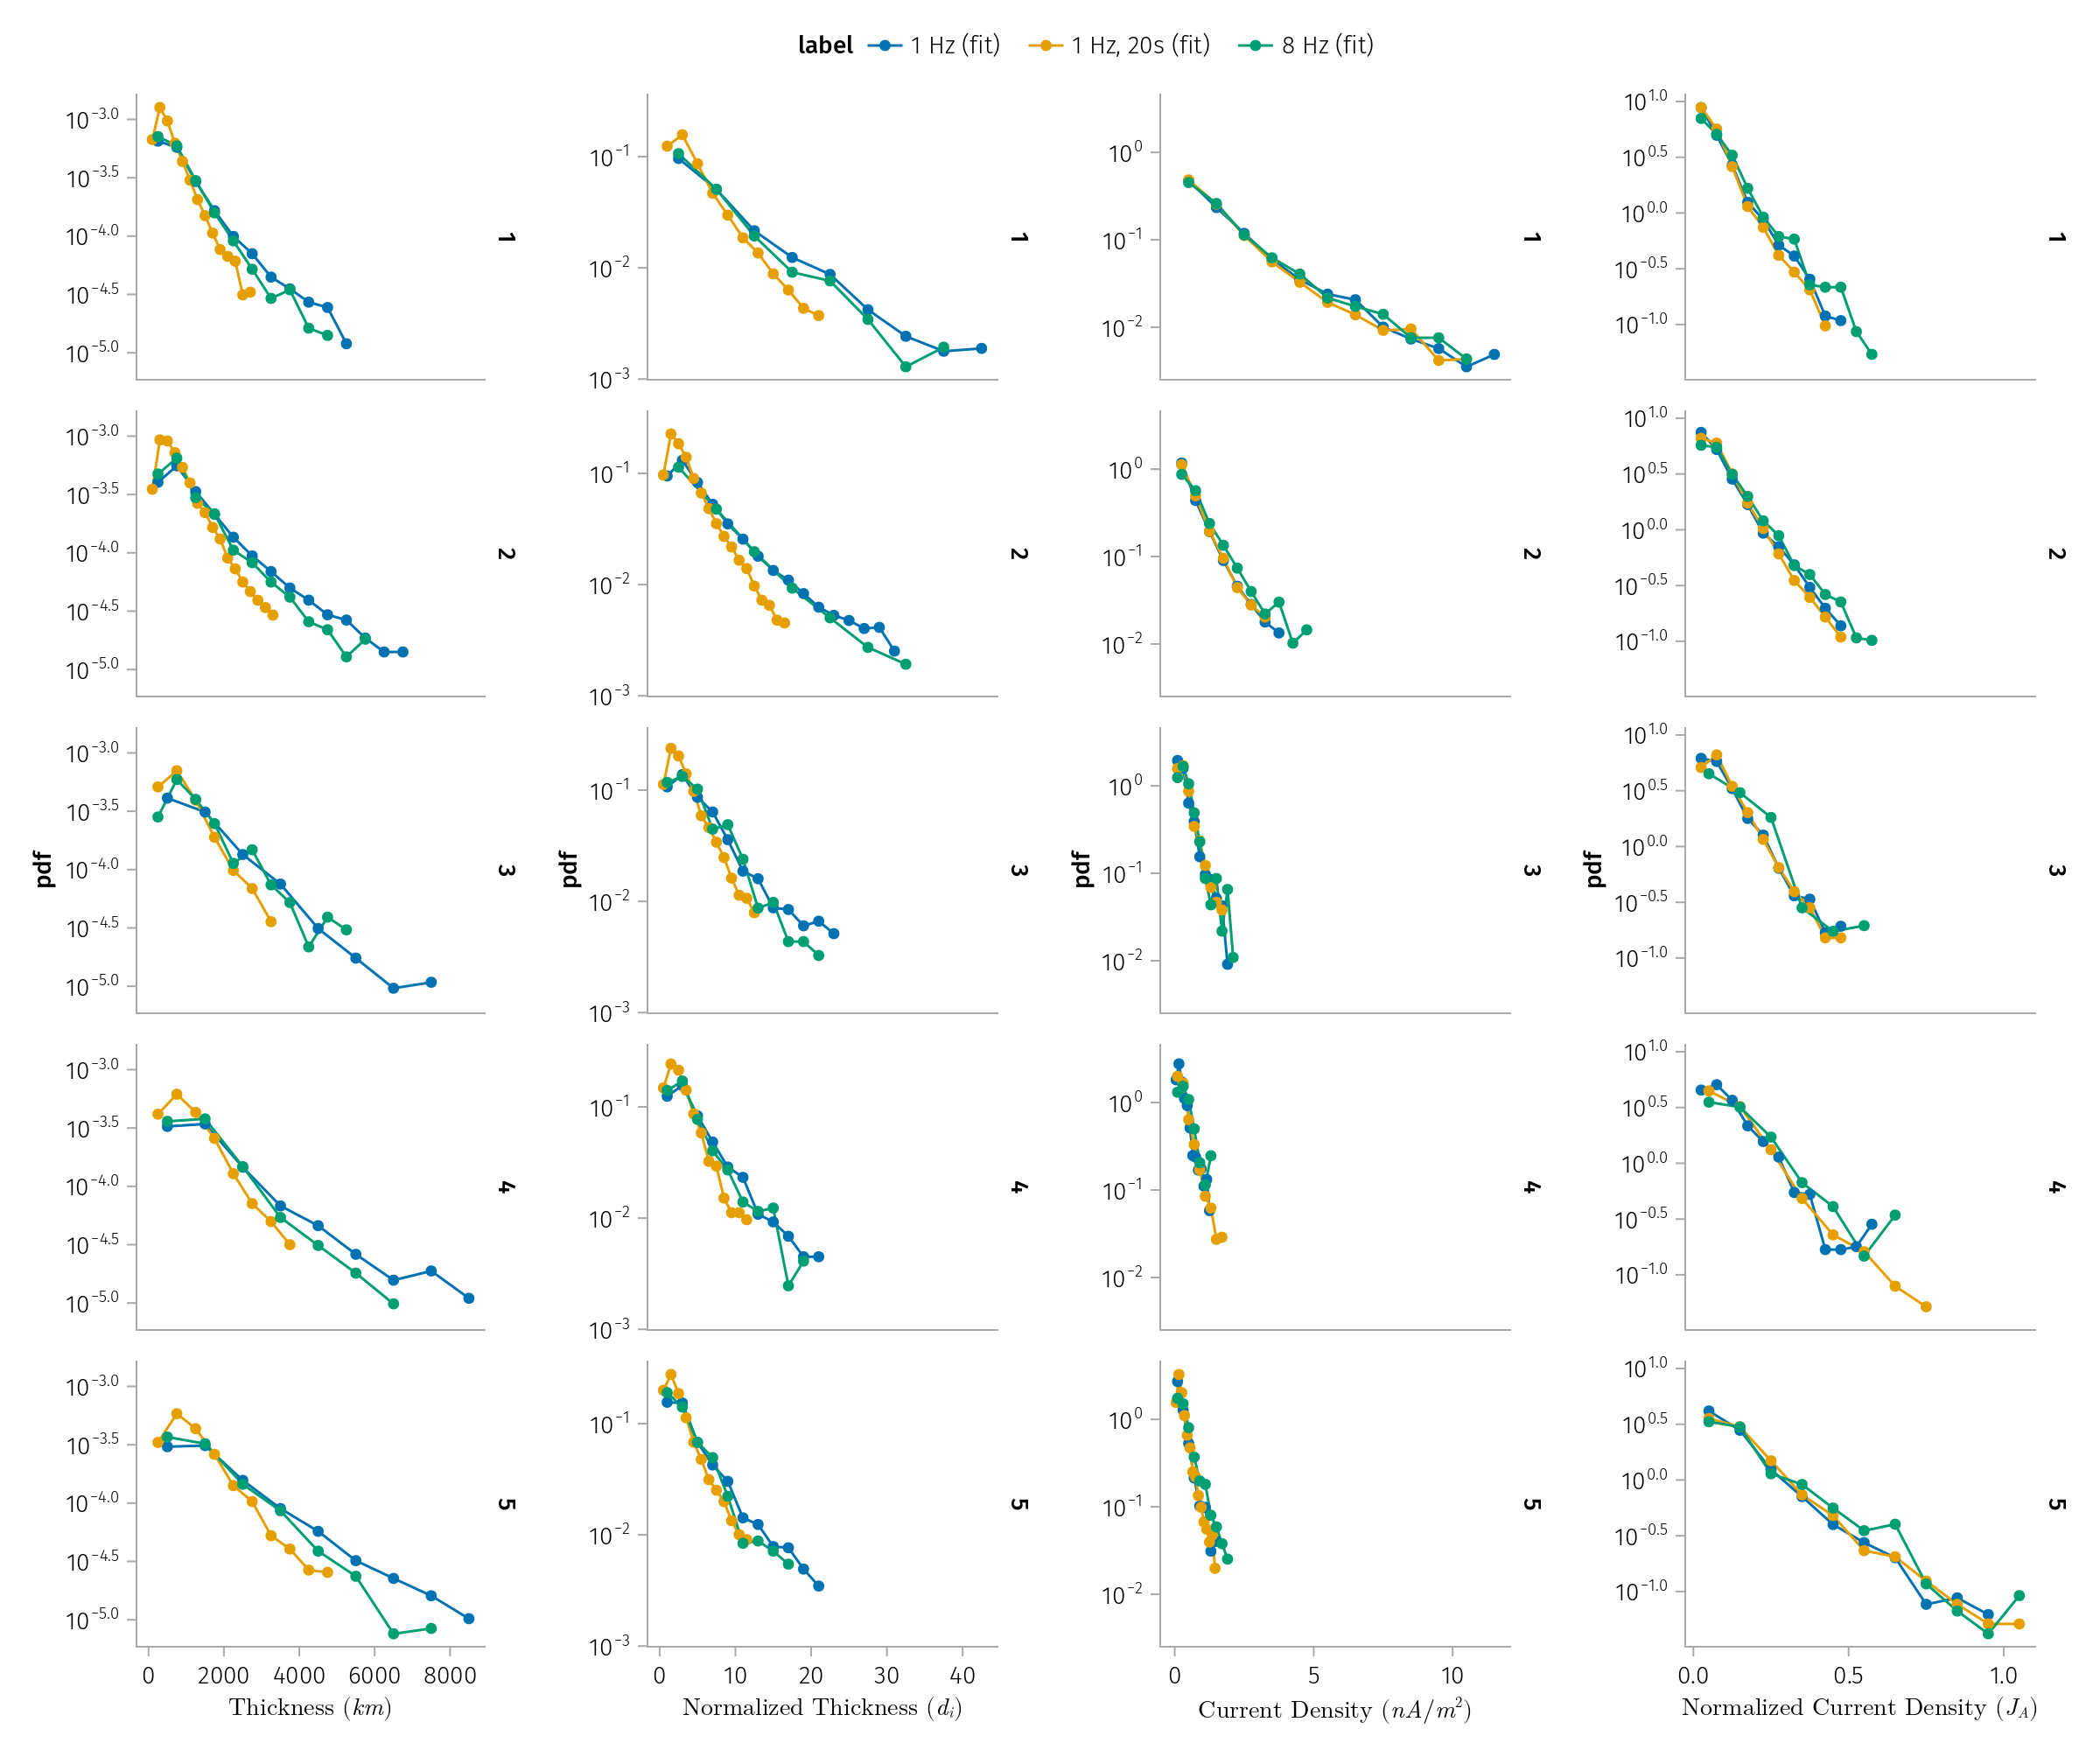

In [19]:
#| label: fig-l-j-r-fit
fig = plot_l_j_r_hist(j_events)
fig

In [20]:
#| output: false

@rput j_events_der
@rput j_events
@rput j_events_tau_20_fit

R"""
library(ggplot2)
library(ggpubr)
library(patchwork)
source('utils.R')
"""

R"""

density_plot <- function(df, x, facet.by = "r", strip.position = "top"){
  p <- ggdensity(
    df, 
    x = x, color = "label",
    facet.by = facet.by,
    add = "median", rug = TRUE
  ) %>%
  facet(facet.by, ncol = 1, strip.position = strip.position)
}

plot <- function(
  df,
  L_k_norm_ulim = 40,
  j0_k_ulim = 8,
  j0_k_norm_ulim = 1.2
) {

  p1 <- density_plot(
    filter(df, L_k < 8000), "L_k"
  )
  
  p2 <- density_plot(
    filter(df, L_k_norm < L_k_norm_ulim), "L_k_norm"
  )
  
  p3 <- density_plot(
    filter(df, j0_k < j0_k_ulim), "j0_k"
  )
  
  p4 <- density_plot(
    filter(df, j0_k_norm < j0_k_norm_ulim), "j0_k_norm", strip.position = "right"
  )
  
  p1 <- ggpar(p1, 
      yscale="log10", ylim = c(10^-5, 10^-3)
    ) + labs(x = lab_l)
  
  p2 <- ggpar(p2, 
      yscale="log10", ylim = c(10^-3, 1), ylab=FALSE
    ) + labs(x = lab_l_norm)
  
  p3 <- ggpar(p3,
      yscale="log10", ylim = c(10^-2, 10), ylab=FALSE
    ) + labs(x = lab_j)
  
  p4 <- ggpar(p4,
      yscale="log10", ylim = c(10^-2, 10), ylab=FALSE
    ) + labs(x = lab_j_norm)
  
  tag_pool <- unique(df$r)
  
  p1 <- tag_facet(p1, open = "(a.", tag_pool = tag_pool)
  p2 <- tag_facet(p2, open = "(b.", tag_pool = tag_pool)
  p3 <- tag_facet(p3, open = "(c.", tag_pool = tag_pool)
  p4 <- tag_facet(p4, open = "(d.", tag_pool = tag_pool) + theme(
    strip.background = element_blank(),
    strip.text.x = element_blank()
  )

  p <- p1 + p2 + p3 + p4
  p <- p + plot_layout(nrow = 1, guides = "collect") & theme(legend.position='top')  
}
"""

┌ Warning: RCall.jl: 
│ Attaching package: 'dplyr'
│ 
│ The following objects are masked from 'package:stats':
│ 
│     filter, lag
│ 
│ The following objects are masked from 'package:base':
│ 
│     intersect, setdiff, setequal, union
│ 
│ Loading required package: gridExtra
│ 
│ Attaching package: 'gridExtra'
│ 
│ The following object is masked from 'package:dplyr':
│ 
│     combine
│ 
│ 
│ Attaching package: 'egg'
│ 
│ The following object is masked from 'package:ggpubr':
│ 
│     ggarrange
│ 
│ 
│ Attaching package: 'arrow'
│ 
│ The following object is masked from 'package:utils':
│ 
│     timestamp
│ 
│ 
│ Attaching package: 'scales'
│ 
│ The following object is masked from 'package:purrr':
│ 
│     discard
│ 
└ @ RCall /Users/zijin/.julia/packages/RCall/dDAVd/src/io.jl:172


RObject{ClosSxp}
function (df, L_k_norm_ulim = 40, j0_k_ulim = 8, j0_k_norm_ulim = 1.2) 
{
    p1 <- density_plot(filter(df, L_k < 8000), "L_k")
    p2 <- density_plot(filter(df, L_k_norm < L_k_norm_ulim), 
        "L_k_norm")
    p3 <- density_plot(filter(df, j0_k < j0_k_ulim), "j0_k")
    p4 <- density_plot(filter(df, j0_k_norm < j0_k_norm_ulim), 
        "j0_k_norm", strip.position = "right")
    p1 <- ggpar(p1, yscale = "log10", ylim = c(10^-5, 10^-3)) + 
        labs(x = lab_l)
    p2 <- ggpar(p2, yscale = "log10", ylim = c(10^-3, 1), ylab = FALSE) + 
        labs(x = lab_l_norm)
    p3 <- ggpar(p3, yscale = "log10", ylim = c(10^-2, 10), ylab = FALSE) + 
        labs(x = lab_j)
    p4 <- ggpar(p4, yscale = "log10", ylim = c(10^-2, 10), ylab = FALSE) + 
        labs(x = lab_j_norm)
    tag_pool <- unique(df$r)
    p1 <- tag_facet(p1, open = "(a.", tag_pool = tag_pool)
    p2 <- tag_facet(p2, open = "(b.", tag_pool = tag_pool)
    p3 <- tag_facet(p3, open = "(c.", tag_pool = tag_poo

In [21]:
#| output: false
R"""
# plot(j_events_der)
# save_plot("l_j_r_der", width = 15, height = 10)

plot(j_events)
save_plot("l_j_r_fit", width = 15, height = 10)
"""

┌ Warning: RCall.jl: Warning: Transformation introduced infinite values in continuous y-axis
│ Warning: Transformation introduced infinite values in continuous y-axis
│ Warning: Transformation introduced infinite values in continuous y-axis
│ Warning: Transformation introduced infinite values in continuous y-axis
│ Warning: Transformation introduced infinite values in continuous y-axis
│ Warning: Transformation introduced infinite values in continuous y-axis
│ Warning: Transformation introduced infinite values in continuous y-axis
└ @ RCall /Users/zijin/.julia/packages/RCall/dDAVd/src/io.jl:172
┌ Warning: RCall.jl: Warning: Transformation introduced infinite values in continuous y-axis
│ Warning: Transformation introduced infinite values in continuous y-axis
│ Warning: Transformation introduced infinite values in continuous y-axis
│ Warning: Transformation introduced infinite values in continuous y-axis
│ Warning: Transformation introduced infinite values in continuous y-axis
│ Warning

RObject{StrSxp}
../figures/l_j_r_fit.pdf


[l_j_r_fit](../figures/l_j_r_fit.png)

[l_j_r_der](../figures/l_j_r_der.png)

### Plot the median of discontinuity properties with radial distance

In [103]:
function q25(x)
    quantile(x, 0.25)
end

function q75(x)
    quantile(x, 0.75)
end

function stat_info(df)
    cols = [:L_k, :L_k_norm, :j0_k, :j0_k_norm]
    funcs = [median mean std q25 q75]
    group_cols = [:r, :label]
    
    @chain df begin
        groupby(group_cols)
        combine(cols .=> funcs)
    end
end

col = "L_k"
stat_info(j_events)[:, "$(col)_median"]

15-element Vector{Float64}:
  778.1492135059101
 1090.7343087931915
 1268.7318847139247
 1487.0954287365016
 1618.8611226298128
  734.1586231974484
  907.399617215176
 1195.9856252348263
 1357.2216902071673
 1378.3492860602692
  519.9710989502066
  697.3222159741033
  830.0951839086725
  999.2776112939654
 1098.9377386861229

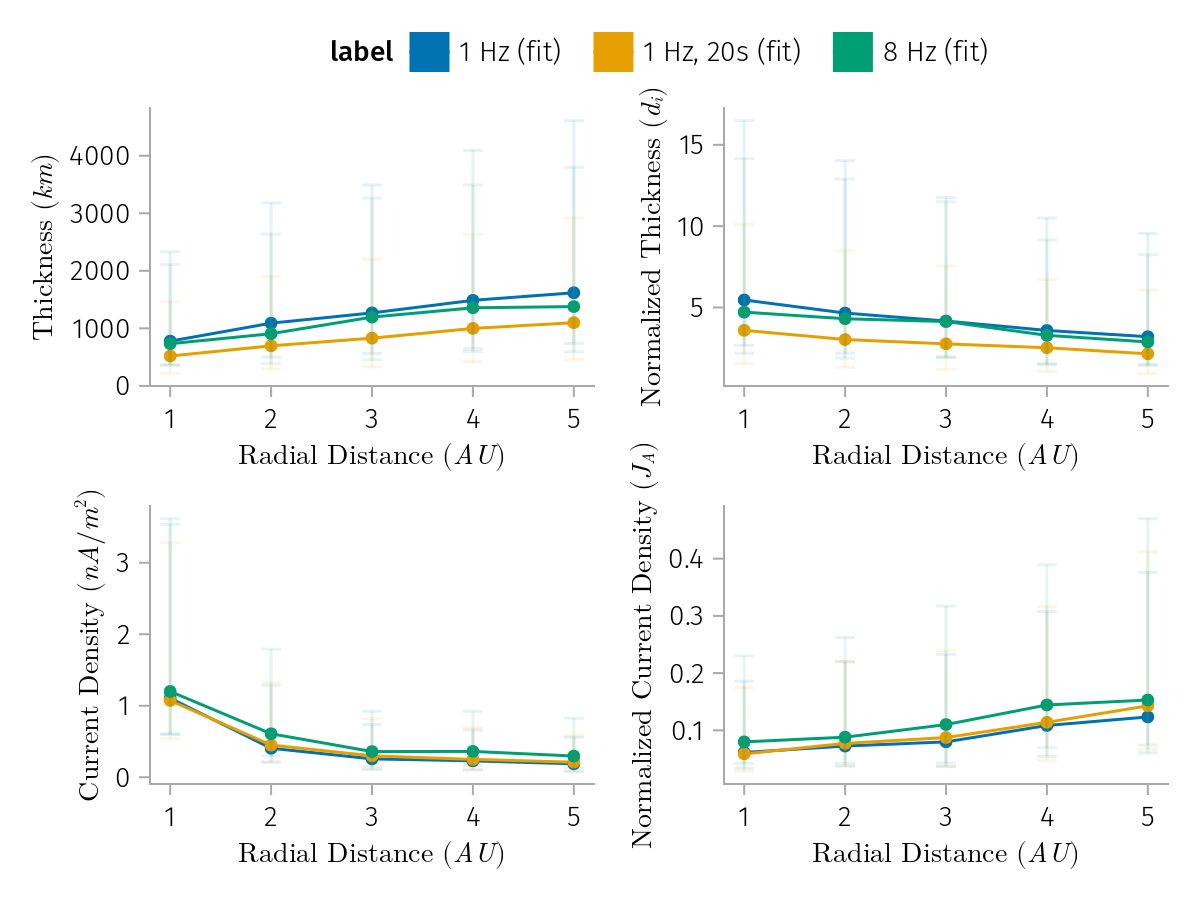

In [108]:
### Plot the median of discontinuity properties with radial distance
function plot_median_r(df)
    df_m = stat_info(df)

    fig = Figure()
    plt = data(df_m) * mapping(:r => r_lab, color=:label)

    mappings = [
        ("L_k", l_lab),
        ("L_k_norm", l_norm_lab),
        ("j0_k", j_lab),
        ("j0_k_norm", j_norm_lab)
    ]

    function plt_map(plt, col, label)
        plt *= mapping("$(col)_median" => label)
        lines_map = (visual(Lines) + visual(Scatter))
        errorbars_map = mapping("$(col)_q25", "$(col)_q75") * visual(Errorbars, alpha=0.1, whiskerwidth=10)
        plt * (lines_map + errorbars_map)
    end

    plts = [plt_map(plt, col, label) for (col, label) in mappings]
    popositions = [(1, 1), (1, 2), (2, 1), (2, 2)] # Define grid positions
    grids = [draw!(fig[pos...], plt) for (pos, plt) in zip(popositions, plts)]
    pretty_legend!(fig, grids[1])

    fig
end

plot_median_r(j_events)

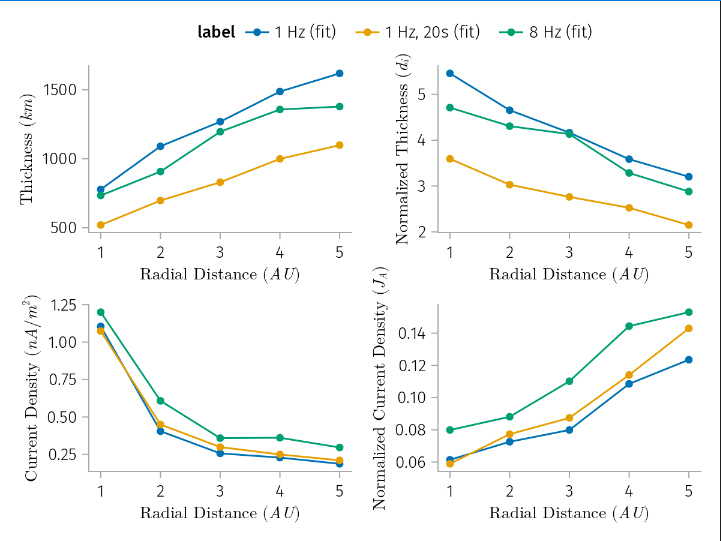

### Plot different radial distances in the same plot

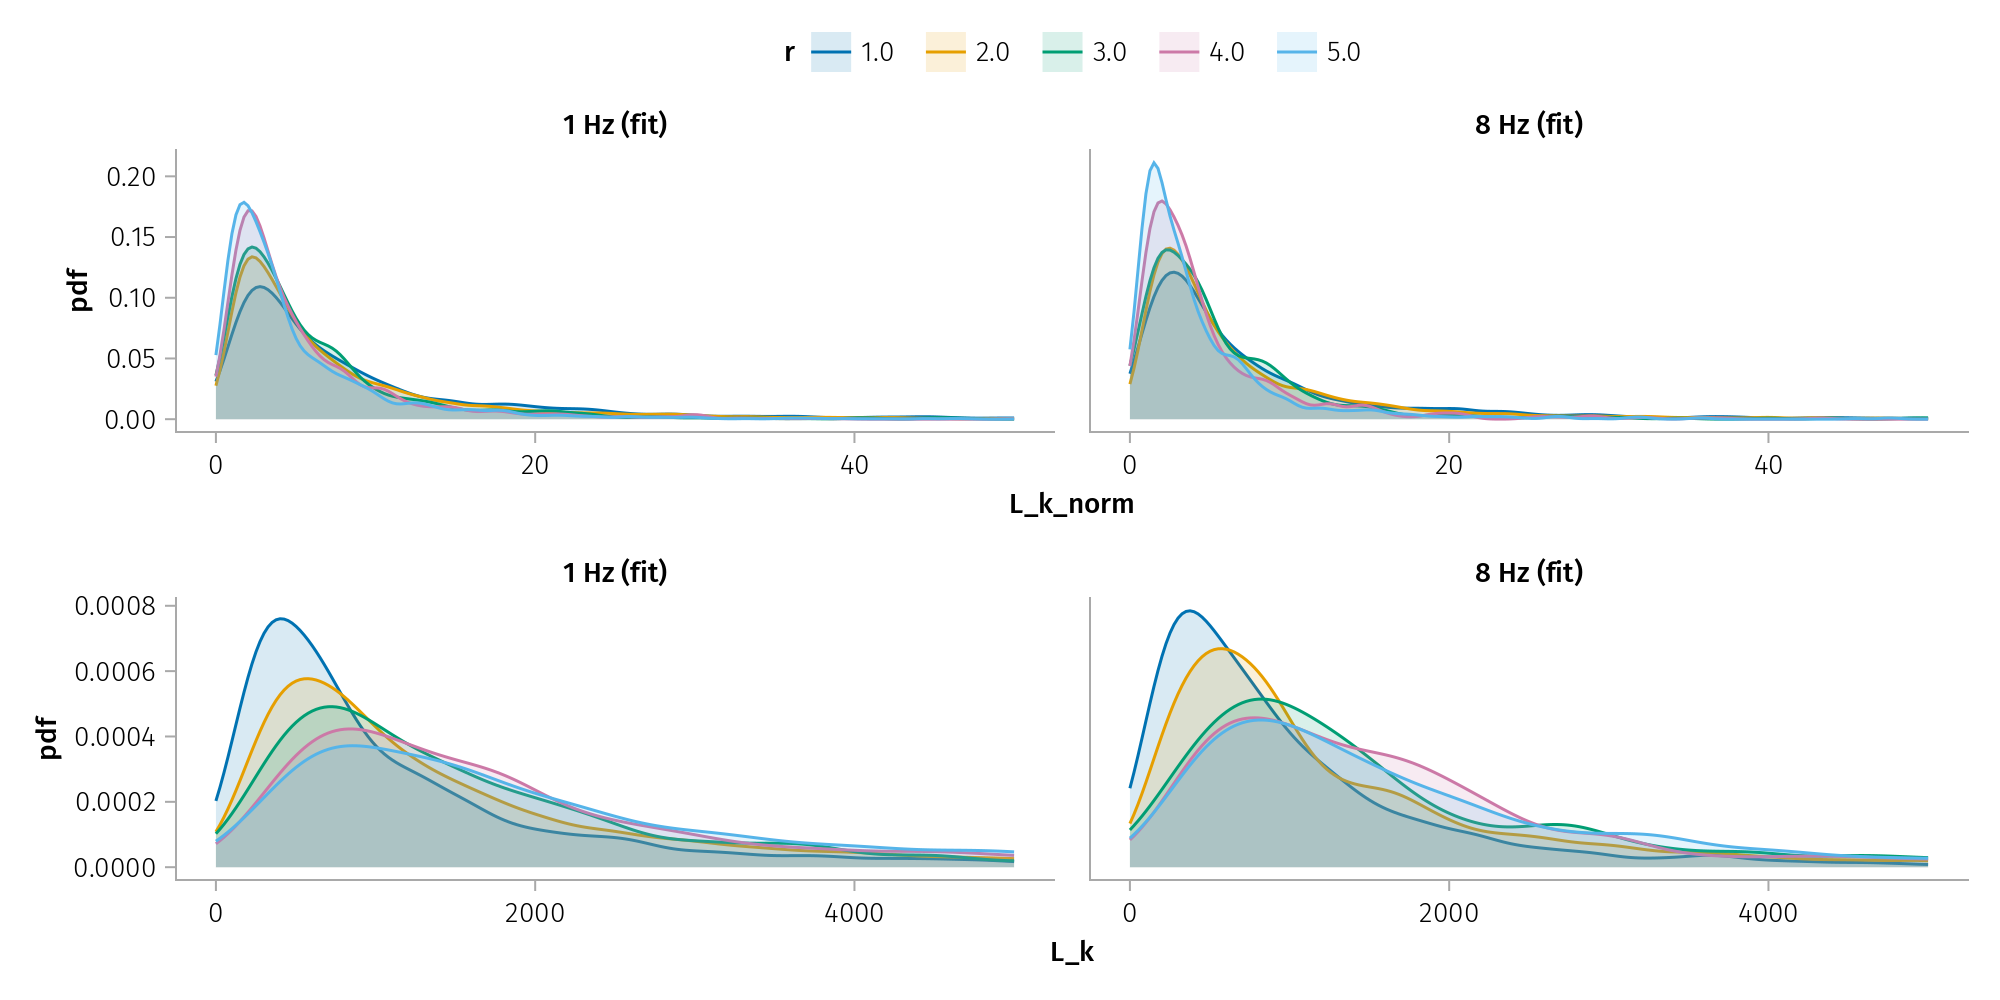

In [54]:
#| label: fig-l-r-fit
function plot_l_r_one(df)
    fig = Figure(size=(1000, 500))

    plt = data(df) * mapping(col=:label, color=:r)
    
    grid1 = draw!( fig[1, 1:2], plt * mapping(:L_k_norm) * density(datalimits=((0, 50),)) )
    grid2 = draw!( fig[2, 1:2], plt * mapping(:L_k) * density(datalimits=((0, 5000),)) )
    legend!(fig[0, 1:end], grid1, titleposition=:left, orientation=:horizontal)

    fig
end

plot_l_r_one(j_events)

## Plasma properties with radial distance

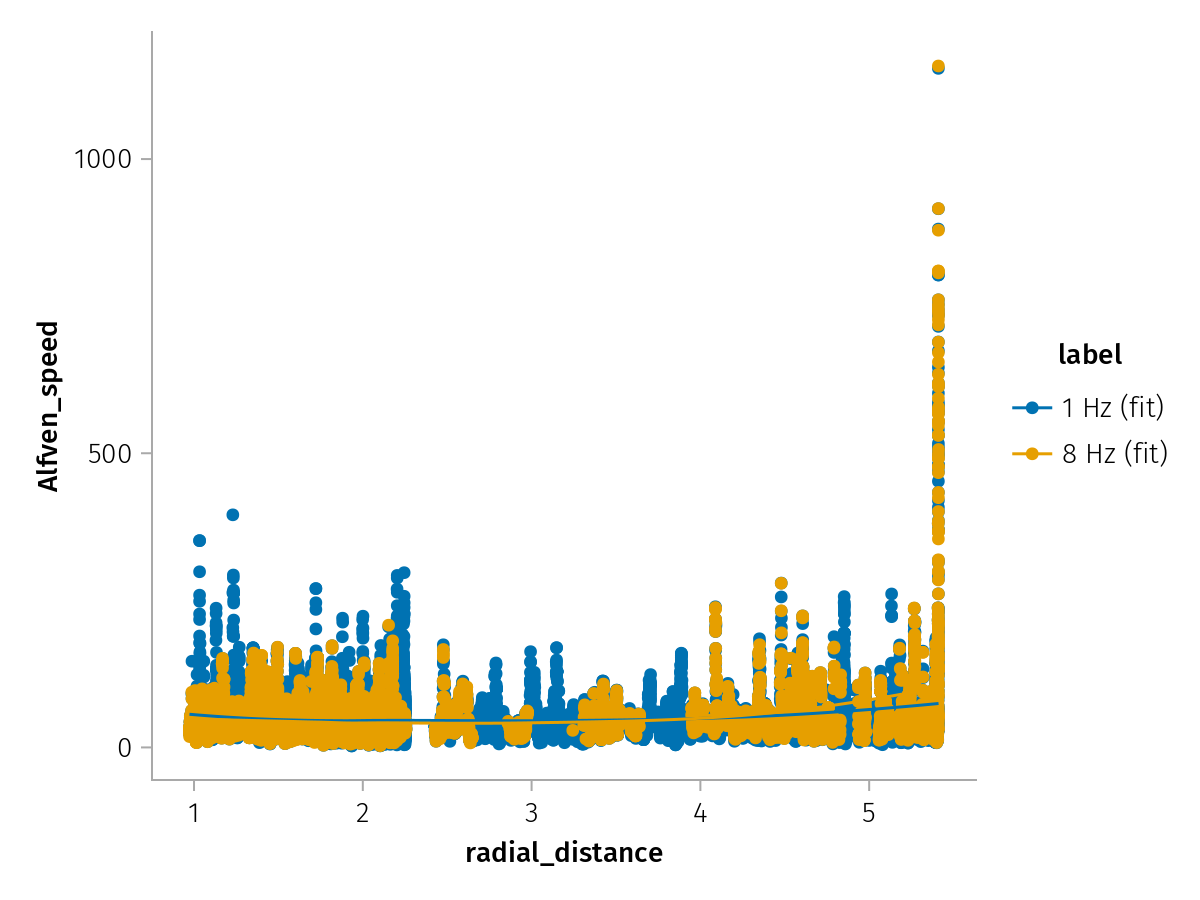

In [66]:
plt = data(j_events) * mapping(:radial_distance, :Alfven_speed, color=:label) * (visual(Scatter) + smooth())
plt |> draw

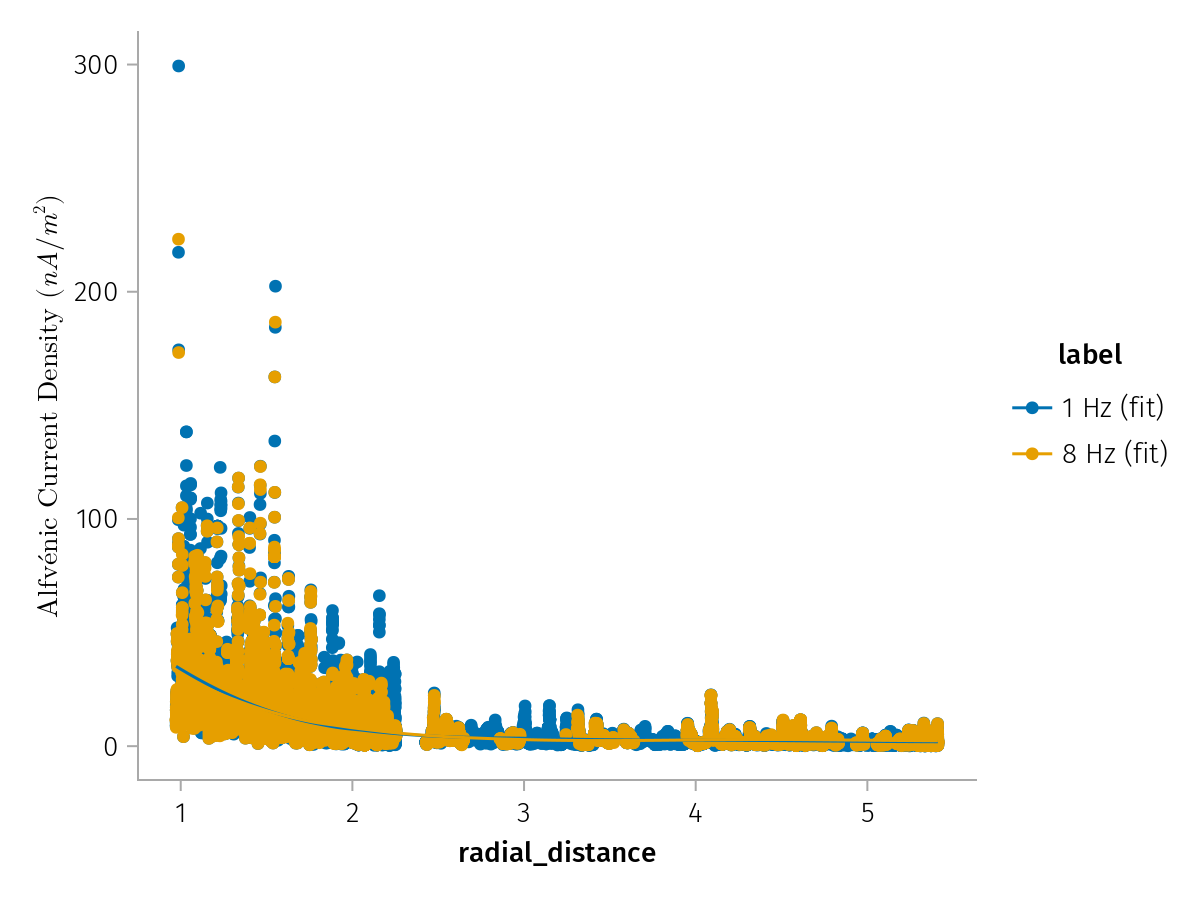

In [64]:
plt = data(j_events) * mapping(:radial_distance, jA_map, color=:label) * (visual(Scatter) + smooth())
plt |> draw

In [79]:
using Statistics

In [86]:
# groupby r and describe the data for each group 
# j_events |> @groupby(_.r) |> @map({r=key(_), j0_k=describe(_.j0_k), L_k=describe(_.L_k)})
@chain j_events begin
    groupby(:r)
    combine(:plasma_density =>  mean, :ion_inertial_length => mean, :b_mag => mean) 
end

5×4 DataFrame
 Row │ r       plasma_density_mean  ion_inertial_length_mean  b_mag_mean 
     │ String  Float64              Float64                   Float64    
─────┼───────────────────────────────────────────────────────────────────
   1 │ 1.0                3.10512                    152.217     3.75957
   2 │ 2.0                1.42267                    242.722     2.10041
   3 │ 3.0                0.674452                   317.706     1.45649
   4 │ 4.0                0.417696                   434.665     1.3097
   5 │ 5.0                0.343857                   569.222     1.27077

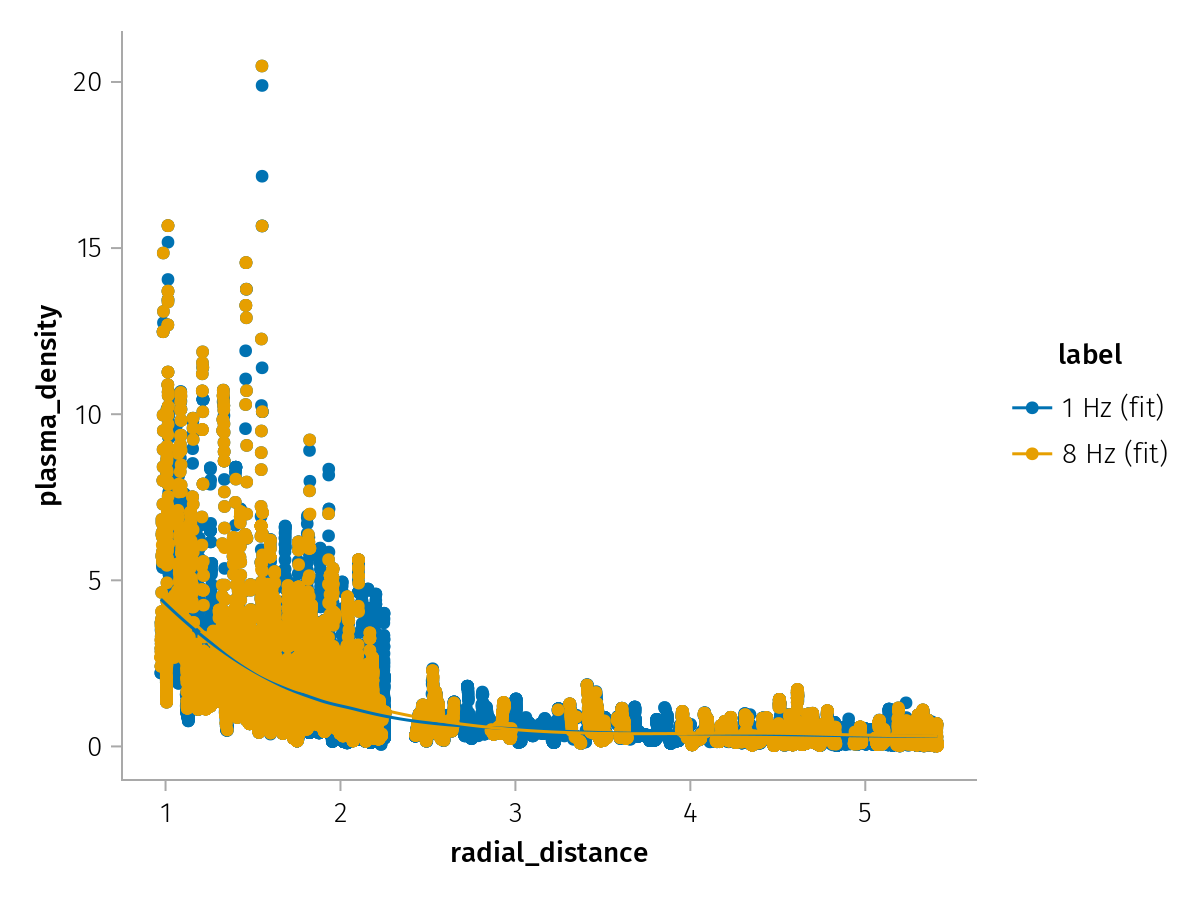

In [67]:
plt = data(j_events) * mapping(:radial_distance, :plasma_density, color=:label) * (visual(Scatter) + smooth())
plt |> draw

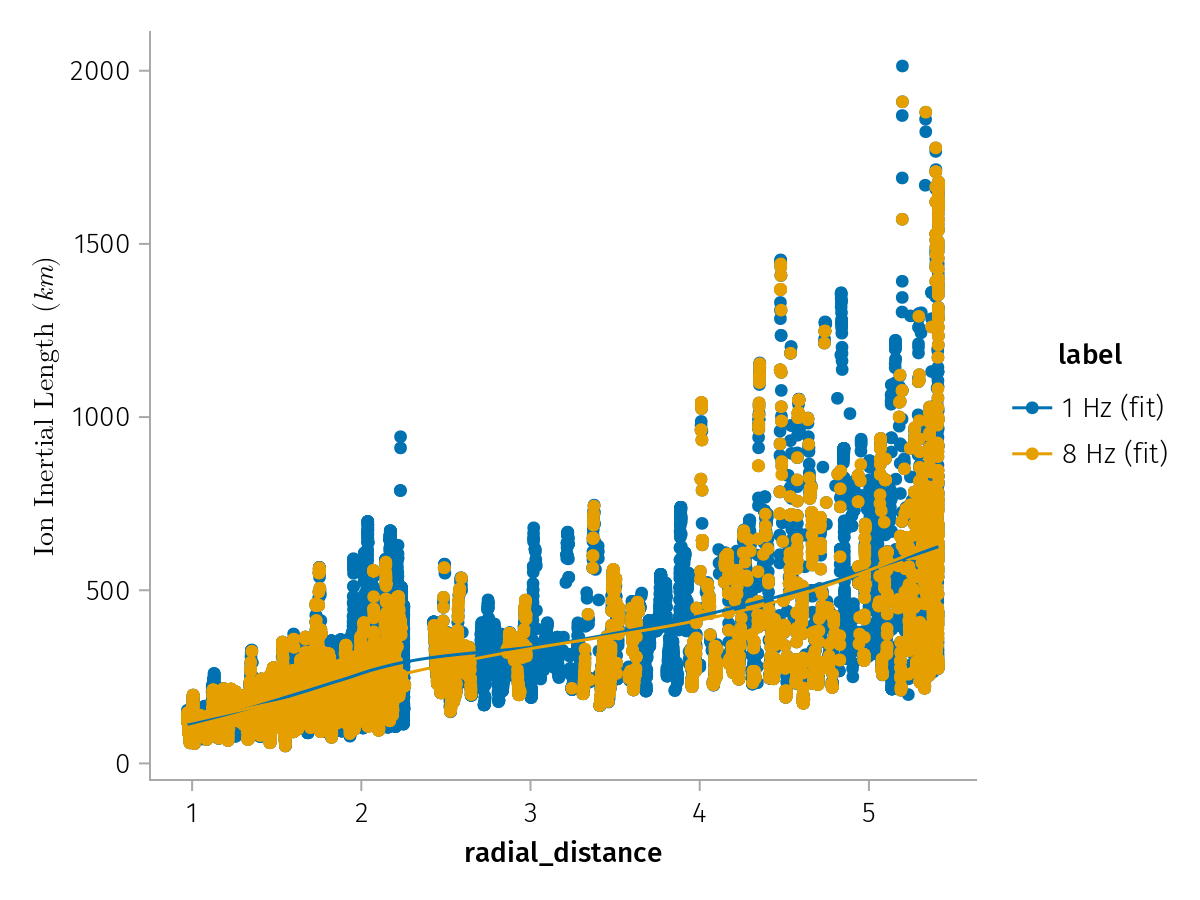

In [65]:
plt = data(j_events) * mapping(:radial_distance, di_map, color=:label) * (visual(Scatter) + smooth())
plt |> draw

## Check discontinuities properties in relation to the local plasma properties

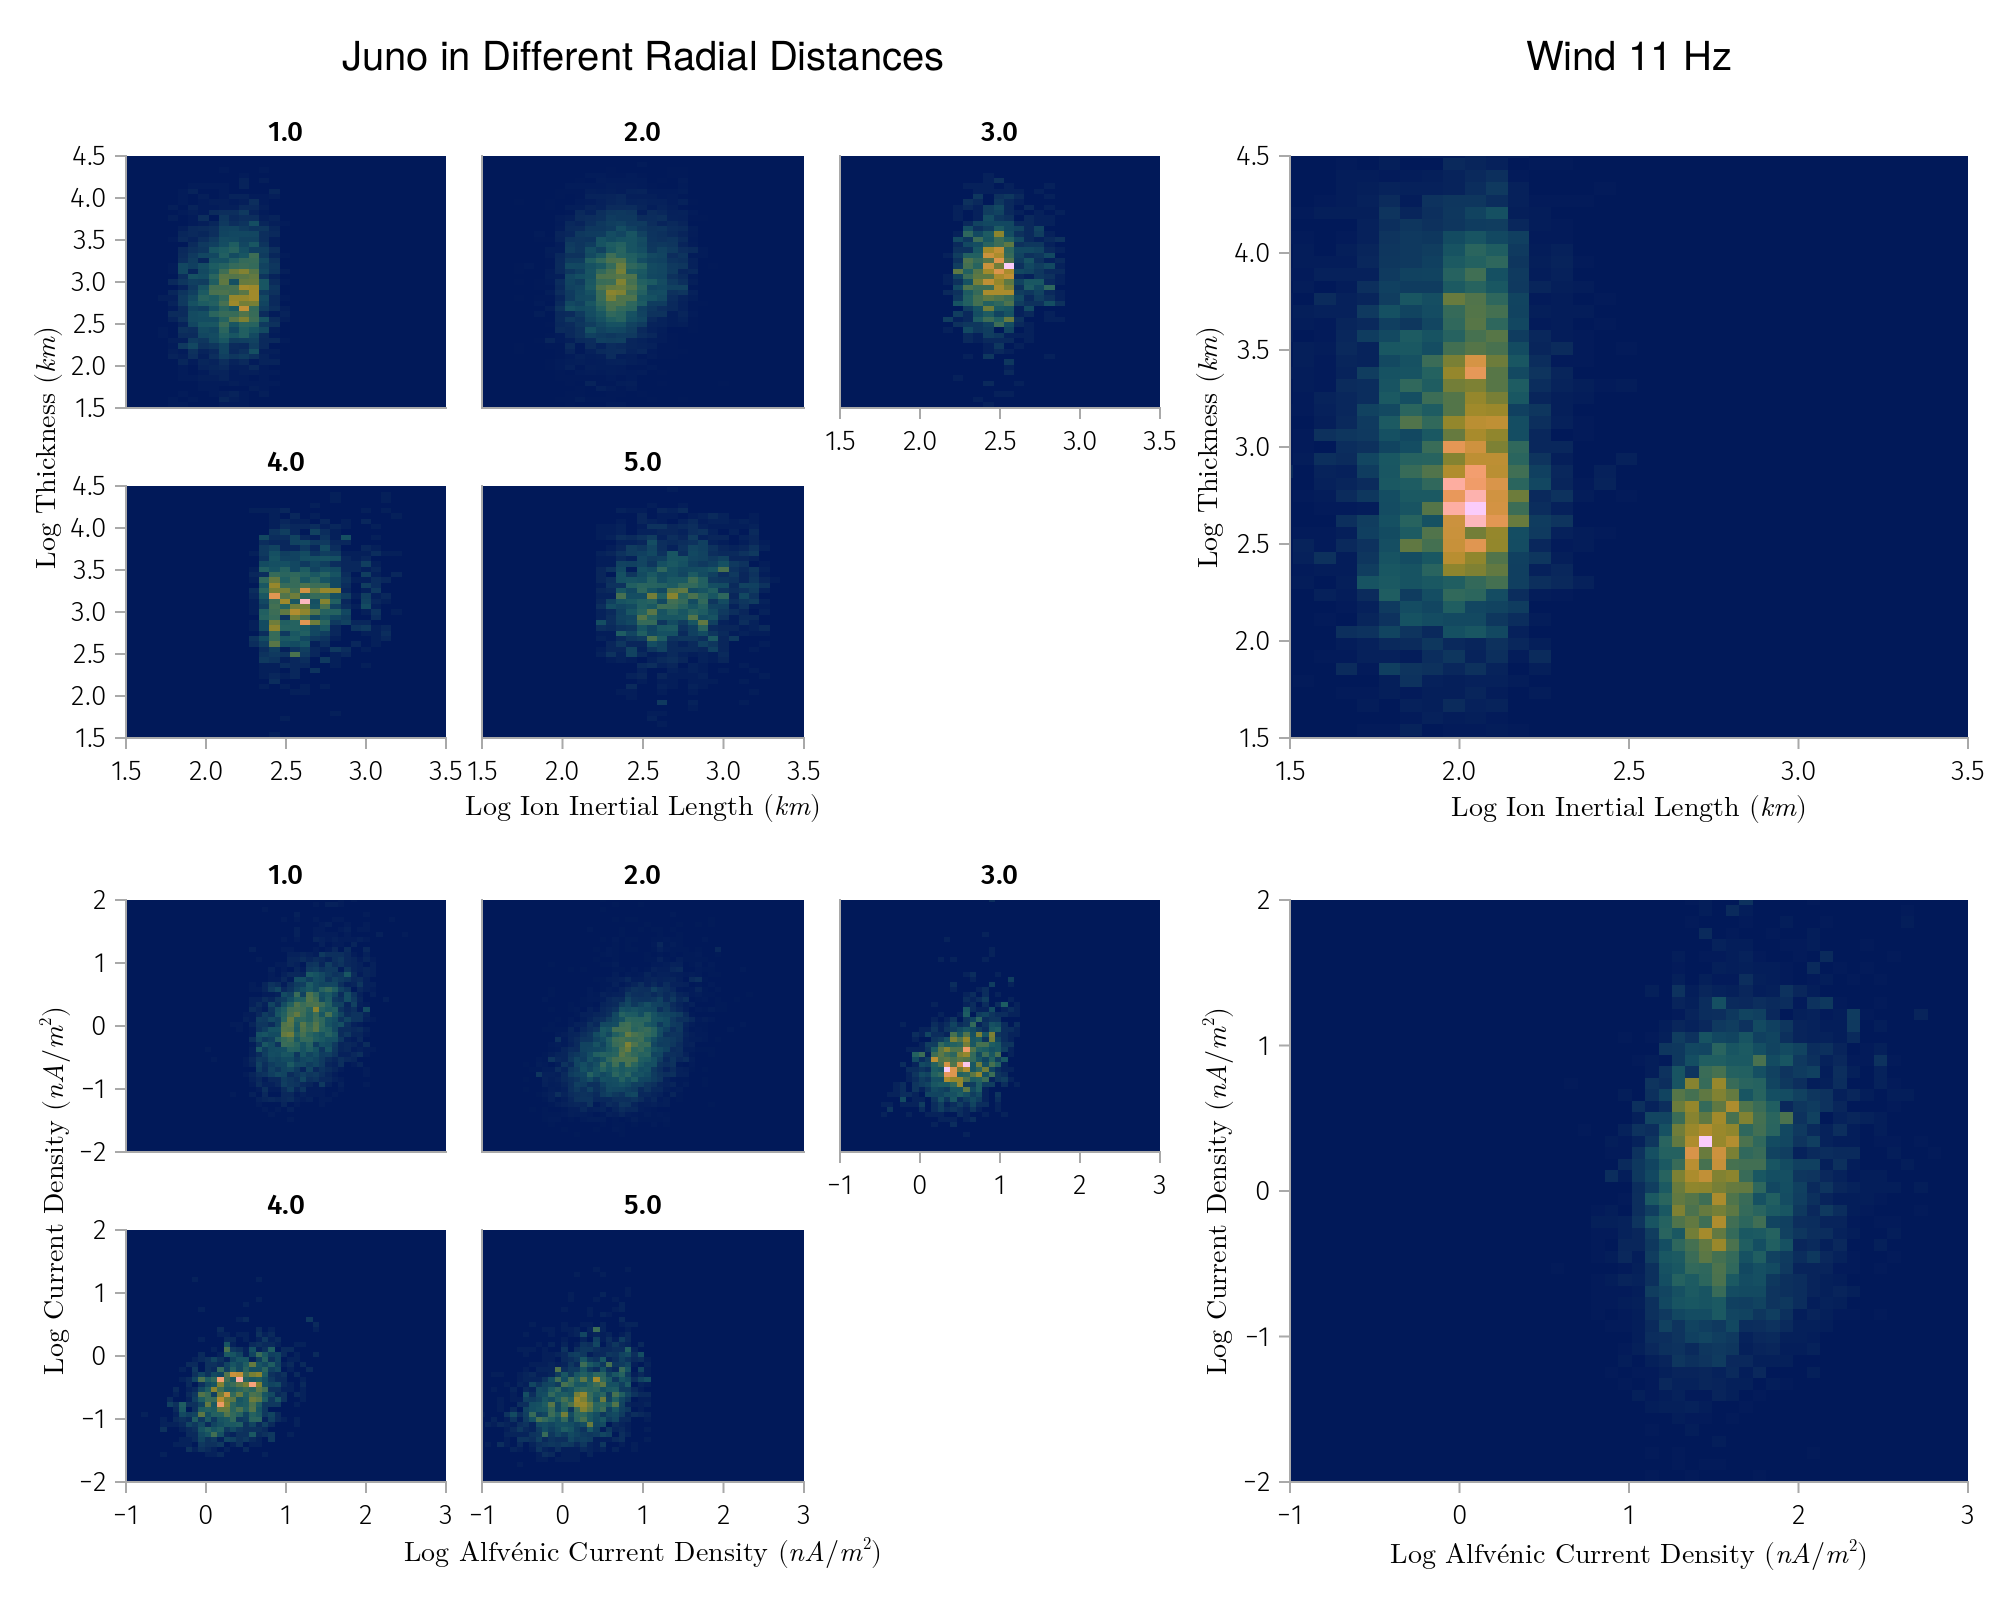

In [ ]:
#| label: fig-local-comp-map
#| column: page
begin
    fig = Figure(size=(1000, 800))

    datalayer = mapping() * visual(Scatter, markersize=1, color=:white, alpha=0.1)

    begin
        layer = histogram(bins=range(1, 5, length=64), normalization=:pdf)
        plt = layer * mapping(di_log_map, l_log_map)
        plt1 = data(j_events) * mapping(layout=:r) * plt
        plt2 = data(w_events) * plt
    
        l_log_limit = ((1.5, 3.5), (1.5, 4.5))
        axis = (;limits=l_log_limit)
        draw!(fig[1:2,1:3], plt1, axis=axis)
        draw!(fig[1:2,4:5], plt2, axis=axis) 
    end

    # Current Density Panels
    begin
        layer = histogram(bins=range(-2, 3, length=64), normalization=:pdf)
        plt = layer * mapping(jA_log_map, j_log_map)
        plt3 = data(j_events) * mapping(layout=:r) * plt
        plt4 = data(w_events) * plt
    
        j_log_limit = ((-1, 3), (-2, 2))
        axis = (;limits=j_log_limit)
        draw!(fig[3:4,1:3], plt3, axis=axis)
        draw!(fig[3:4,4:5], plt4, axis=axis)
    end

    # Make ablines across different r panels
    # begin
        # ablines_data = (; intercepts=[-3,-1,1], slopes=[1,1,1]) 
        # lines = data(ablines_data) * mapping(:intercepts, :slopes) * visual(ABLines, linestyle=:dash)
        # draw!(fig[3:4,1:3], lines)
    # end

    Label(fig[0,1:3], "Juno in Different Radial Distances", fontsize=20)
    Label(fig[0,4:5], "Wind 11 Hz", fontsize=20)

    fig
end

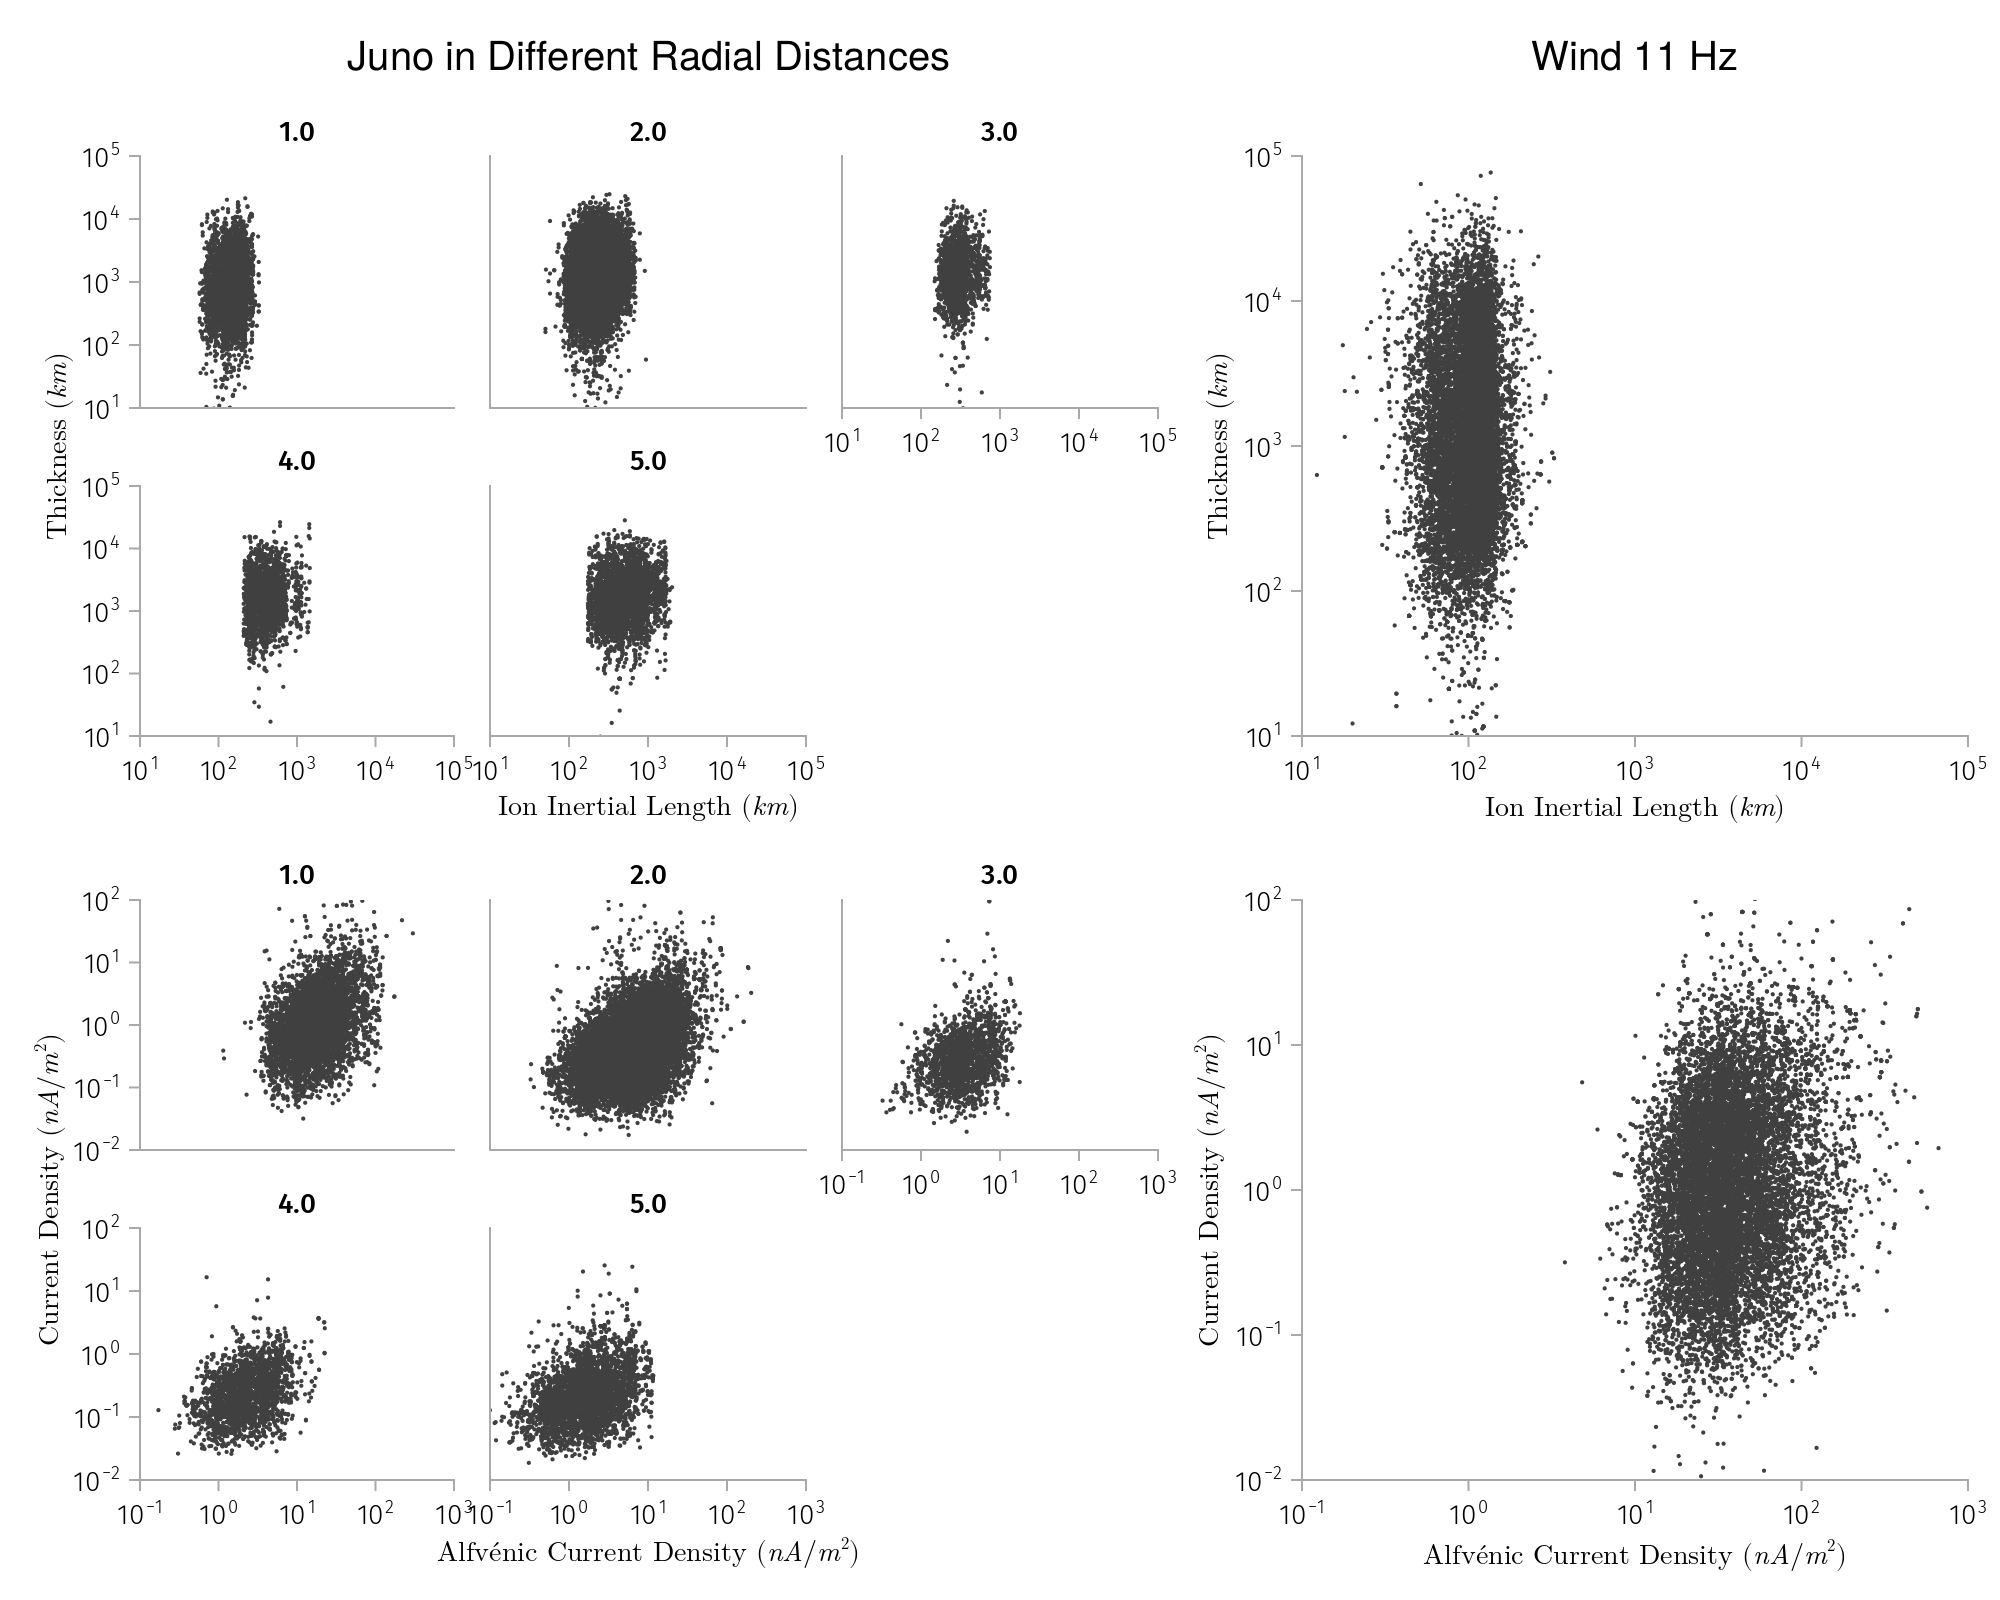

In [ ]:
#| label: fig-l-comp
begin
    fig = Figure(size=(1000, 800))

    pdflayer = density() * visual(Contour)
    # small scatter points
    datalayer = mapping() * visual(Scatter, markersize=3)

    # layer = pdflayer + datalayer
    layer = datalayer
    plt = layer * mapping(di_map, l_map)
    plt1 = data(j_events) * mapping(layout=:r) * plt
    plt2 = data(w_events) * plt

    l_limit = ((10^1, 10^5), (10^1, 10^5))
    axis = merge(log_axis, (;limits=l_limit))
    draw!(fig[1:2,1:3], plt1, axis=axis)
    draw!(fig[1:2,4:5], plt2, axis=axis)

    plt = layer * mapping(jA_map, j_map)
    plt3 = data(j_events) * mapping(layout=:r) * plt
    plt4 = data(w_events) * plt

    j_limit = ((10^-1, 10^3), (10^-2, 10^2))
    axis = merge(log_axis, (;limits=j_limit))
    draw!(fig[3:4,1:3], plt3, axis=axis)
    draw!(fig[3:4,4:5], plt4, axis=axis)


    Label(fig[0,1:3], "Juno in Different Radial Distances", fontsize=20)
    Label(fig[0,4:5], "Wind 11 Hz", fontsize=20)

    fig
end

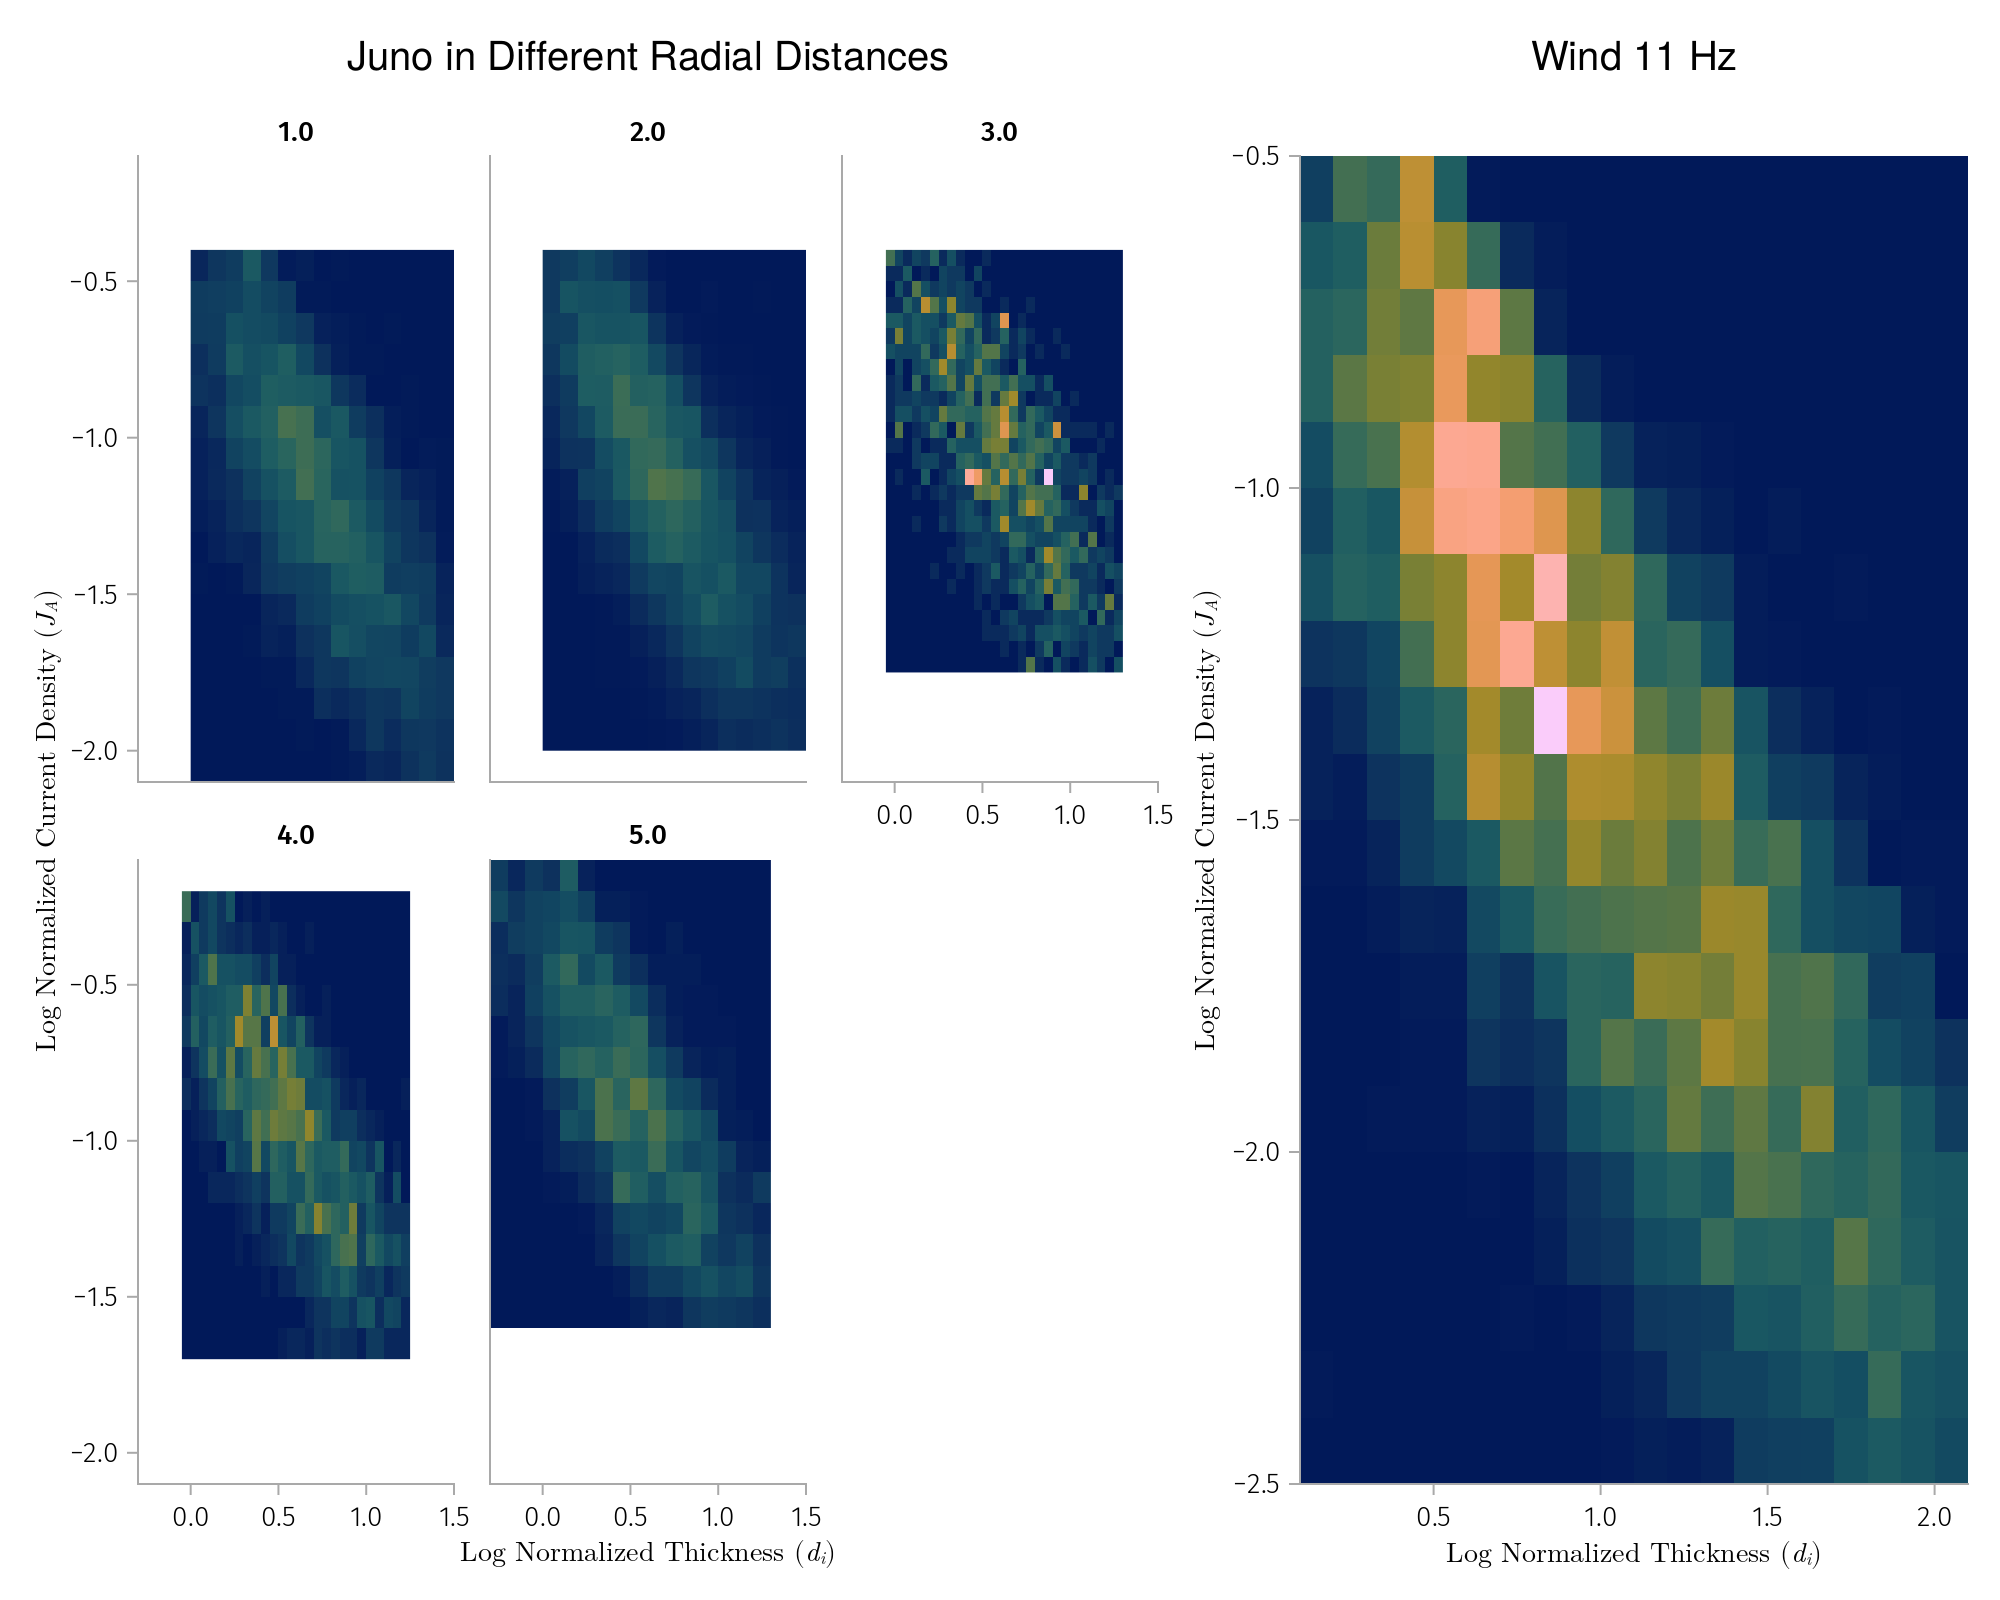

In [ ]:
begin
    fig = Figure(size=(1000, 800))
    datalimits_f = x -> quantile(x, [0.05, 0.95])

    begin
        layer = histogram(bins=24, datalimits=datalimits_f, normalization=:pdf)
        plt = layer * mapping(l_norm_log_map, j_norm_log_map)
        plt1 = data(j_events) * mapping(layout=:r) * plt
        plt2 = data(w_events) * plt

        axis = (;)
        draw!(fig[1:2, 1:3], plt1, axis=axis)
        draw!(fig[1:2, 4:5], plt2, axis=axis)
    end

    Label(fig[0, 1:3], "Juno in Different Radial Distances", fontsize=20)
    Label(fig[0, 4:5], "Wind 11 Hz", fontsize=20)

    fig
end

fig

## Derivative method validation

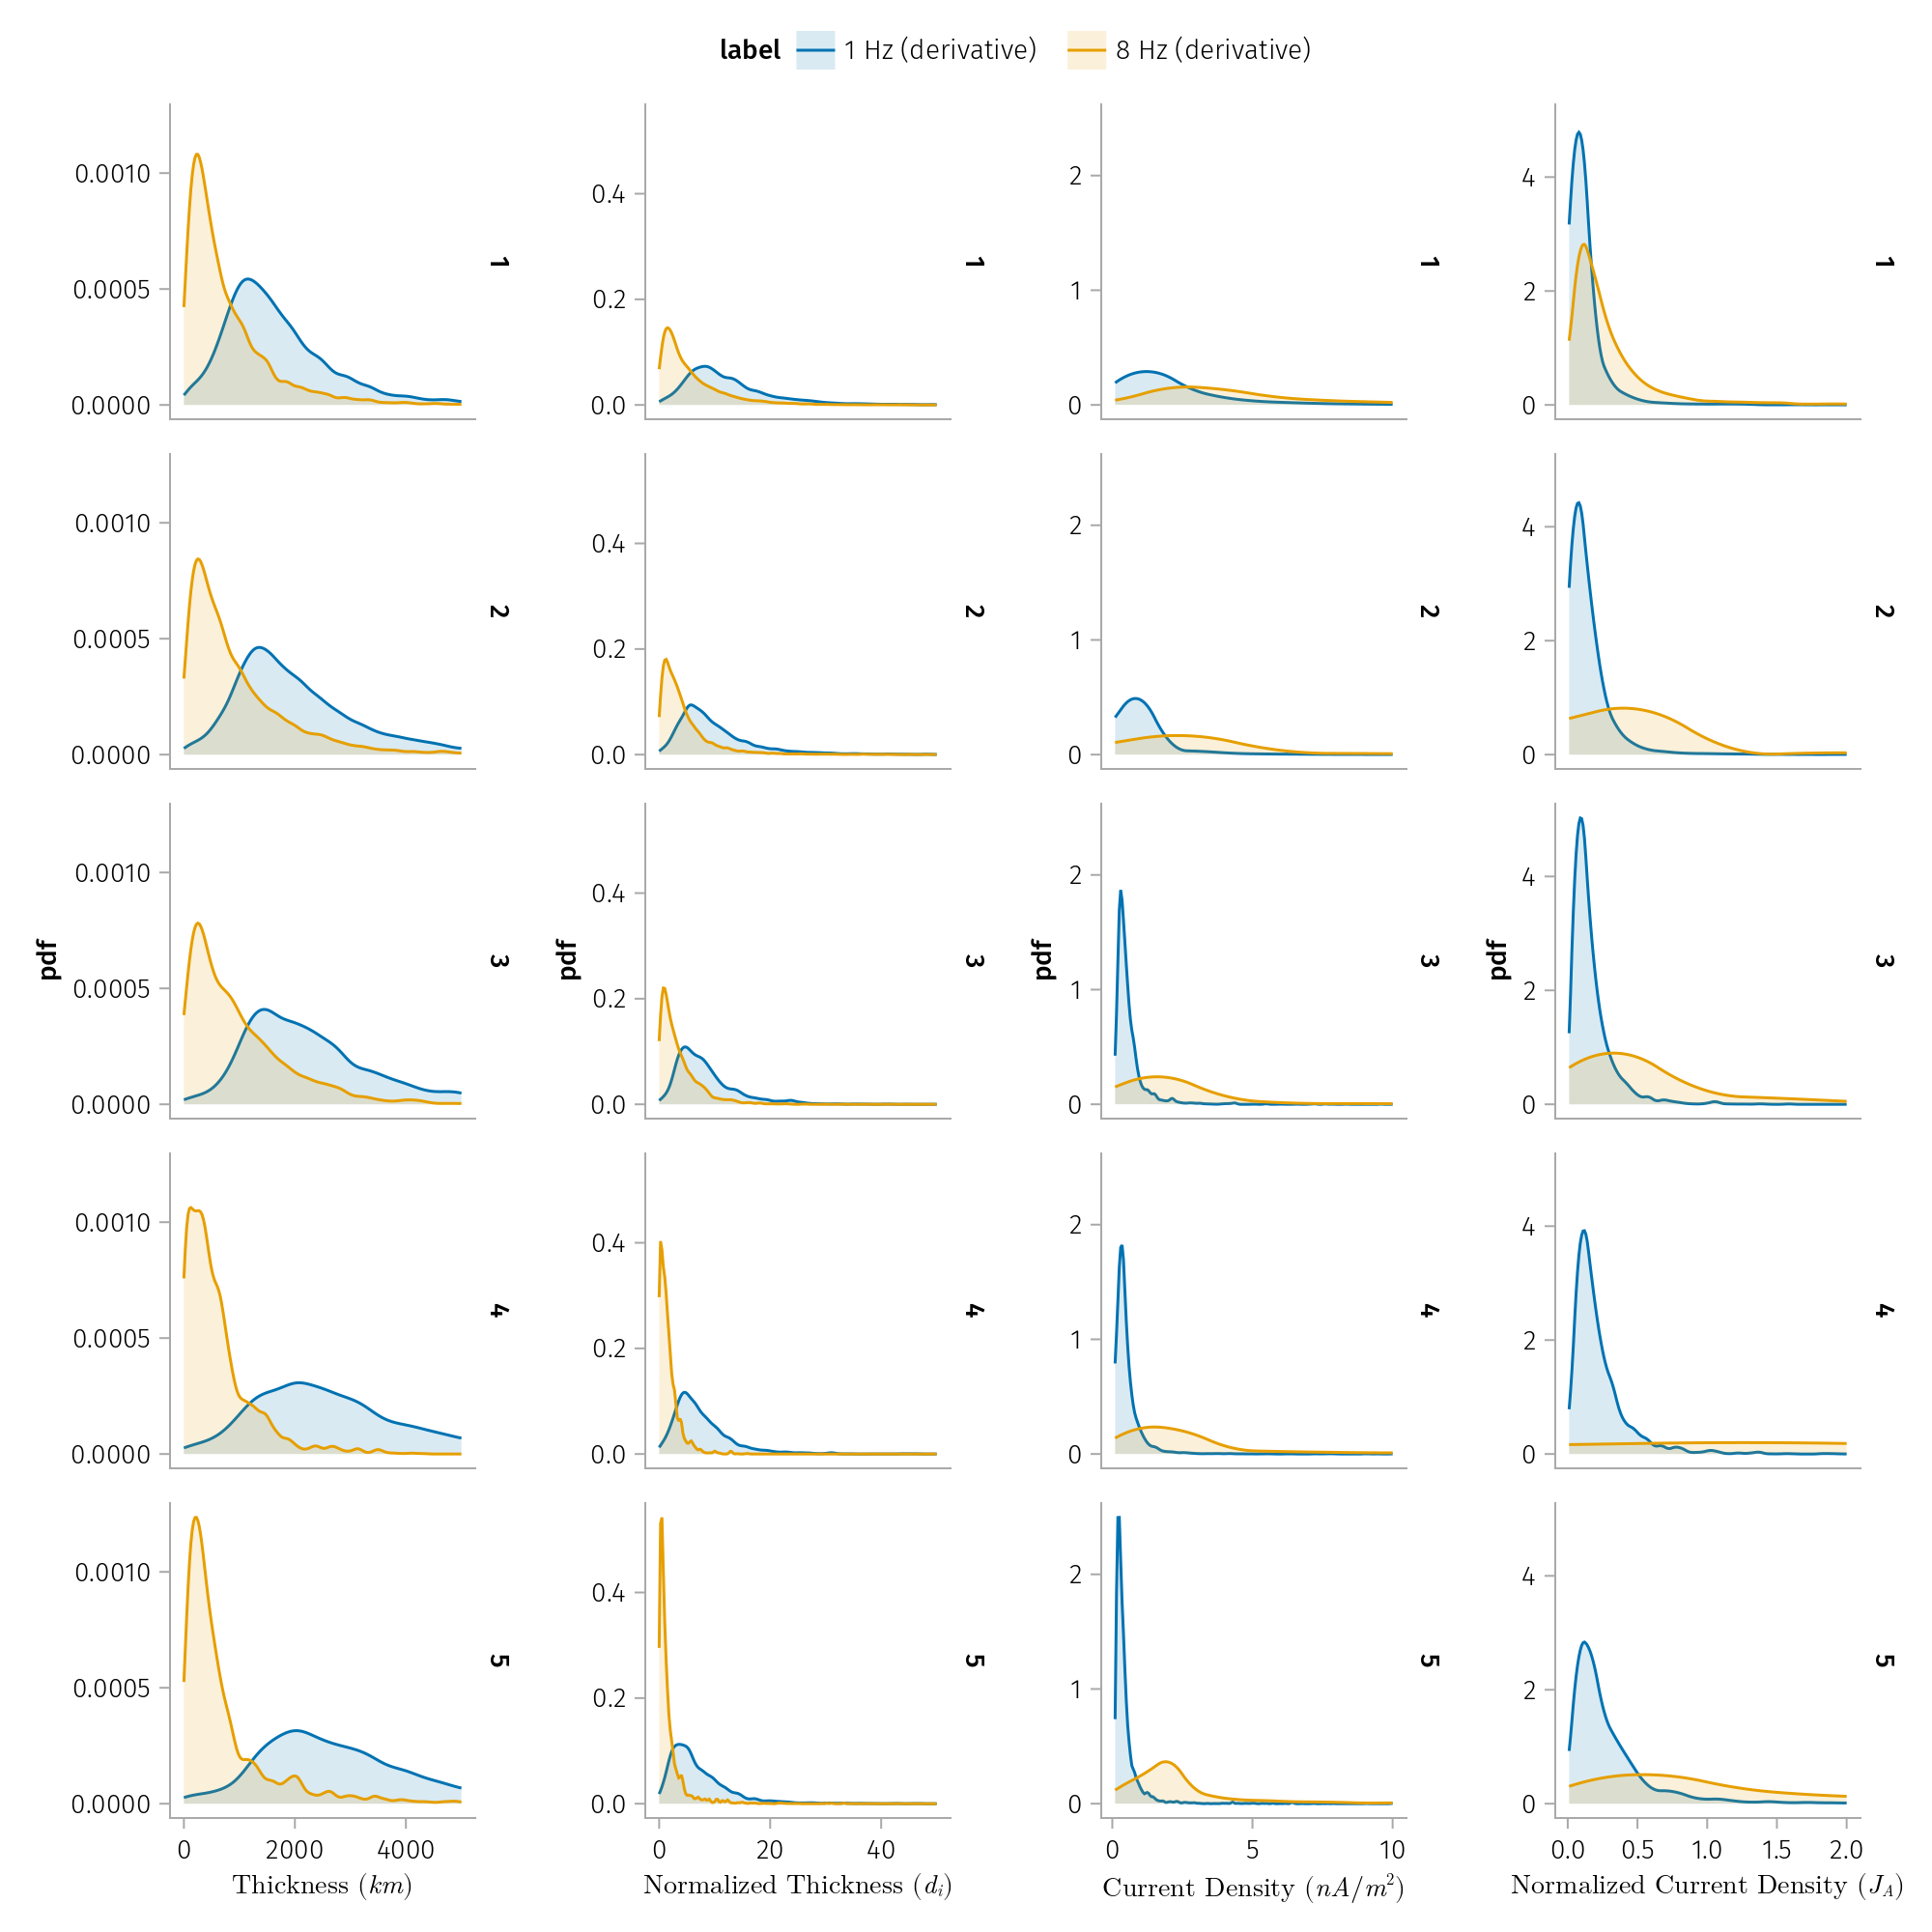

In [16]:
#| label: fig-l-j-r-der

fig = plot_l_j_r(j_events_der)
fig